In [1]:
# Import libraries
import re
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import os, os.path as osp

import nltk  #to install: activate ada,   conda install -c anaconda nltk
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string

import seaborn as sns
sns.set(style="whitegrid")
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def normalize_servings(c_f, servs):
    #input is ingredient quantity in kg
    #interpret servings as a total quantity using the check_quantity function
    tot_servs = servs.str.extract('(\d+)') #find value
    tot_servs=tot_servs.fillna(value='2') #replace missing values with 2
    tot_servs=tot_servs.astype(int) #convert to int
    c_f_norm=c_f/tot_servs[0]
    return c_f_norm

In [3]:
meat_products = ['steak','lamb', 'beef', 'cheese', 'pork', 'turkey', 'chicken', 'tuna', 'egg']


In [4]:
# Define the Fontsize parameters for the plots:
FontSize=14
plt.rcParams['axes.labelsize']=FontSize
plt.rcParams['xtick.labelsize']=FontSize
plt.rcParams['ytick.labelsize']=FontSize
plt.rcParams['legend.fontsize']=FontSize

## Data import and cleaning
For the statistical analysis of the data we drop all recipes for which we were not able to properly retrieve the amount of meat ingredients in order to not create artificial spikes in the distributions. In a later time however we assign the median amount to every type of meat.

In [5]:
#Import and create a CSV dataframe with carbon footprint normalized per serving:

DATA_FOLDER='data'
df1=pd.read_csv(DATA_FOLDER+'/recipes_data1.csv') # Normalized Carbon footprint
df2=pd.read_csv(DATA_FOLDER+'/recipes_data2.csv') # Serving size in extra column
df3=pd.read_csv(DATA_FOLDER+'/recipes_data3.csv')
df4=pd.read_csv(DATA_FOLDER+'/recipes_data4.csv')
df5=pd.read_csv(DATA_FOLDER+'/recipes_data5.csv')
recipes_df=pd.read_csv(DATA_FOLDER+'/recipes_data5.csv')


df2['Carbon footprint']=normalize_servings(df2['Carbon footprint'],df2['Servings'])
df3['Carbon footprint']=normalize_servings(df3['Carbon footprint'],df3['Servings'])
df4['Carbon footprint']=normalize_servings(df4['Carbon footprint'],df4['Servings'])
df5['Carbon footprint']=normalize_servings(df5['Carbon footprint'],df5['Servings'])
df=pd.concat([df1,df2,df3,df4,df5], sort=False)
df.head()

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint,Rating,Website,Servings
0,French Dip Sandwiches Recipe : Rachael Ray : R...,True,"['beef', 'beef', 'beef']","[0.0, 0.17006802721088435, 0.0]",4.591837,5.0,food network,NaN
1,Apple Brown Betty Recipe | MyRecipes.com,False,[],0,0.000000,NaN,myrecipes,NaN
2,Roasted Potatoes with North Indian Spices Reci...,False,[],0,0.000000,NaN,myrecipes,NaN
3,\r\n\tBaked Buffalo Wings Recipe - Allrecipes....,True,['chicken'],[0.0],0.000000,4.4,allrecipes,NaN
4,Baked Lemon-Garlic Chicken with Bell Peppers R...,True,"['chicken', 'chicken']","[0.24499595756670015, 0.24499595756670015]",3.380944,NaN,myrecipes,NaN


In [6]:
## Cleaning
# drop all recipes for which we have NaN or inf values in Carbon footprint or Rating
df_clean=df.replace([np.inf,-np.inf], np.nan).dropna(subset=["Carbon footprint", "Rating"], how="any")
df_clean.head()

#Create seperate dataframes for recipes with and without ingredient in the high carbon footprint list:
df_meat = df_clean[df_clean['Has meat']]
df_meat = df_meat[df_meat['Carbon footprint']!=0.0]
df_no_meat = df_clean[df_clean['Has meat']==False]

## First statistical Exploration of the Data

### Descriptive Statistics
We have collected the information of over 15'000 recipes. 5801 do not contain any ingredient figuring in the list of high carbon footprint ingredients wheras 7949 figure. The mean rating is with 4.41 slightly higher in recipes containing meat than in recipes without with a mean of 4.40.

In [7]:
print('All Recipes:')
print(df_clean.describe())
print('Recipes containing high carbon footprint ingredients:')
print(df_meat.describe())
print('Recipes without high carbon footprint ingredients:')
print(df_no_meat.describe())

All Recipes:
       Carbon footprint        Rating
count      15704.000000  15704.000000
mean           1.101613      4.412615
std            7.257666      0.539040
min            0.000000      0.000000
25%            0.000000      4.200000
50%            0.001200      4.500000
75%            0.228893      4.700000
max          329.725000      5.000000
Recipes containing high carbon footprint ingredients:
       Carbon footprint       Rating
count       7949.000000  7949.000000
mean           2.176340     4.403736
std           10.086084     0.529220
min            0.000120     0.000000
25%            0.014400     4.200000
50%            0.191359     4.500000
75%            1.564626     4.700000
max          329.725000     5.000000
Recipes without high carbon footprint ingredients:
       Carbon footprint       Rating
count            5801.0  5801.000000
mean                0.0     4.427625
std                 0.0     0.547765
min                 0.0     0.000000
25%                 0.

### Correlations

In [8]:
print('Spearman Correlation for all recipes:')
print(df_clean.corr(method='spearman'))
print('Spearman Correlation for meat recipes:')
print(df_meat.corr(method='spearman'))

Spearman Correlation for all recipes:
                  Has meat  Carbon footprint    Rating
Has meat          1.000000          0.715488 -0.038661
Carbon footprint  0.715488          1.000000 -0.008857
Rating           -0.038661         -0.008857  1.000000
Spearman Correlation for meat recipes:
                  Has meat  Carbon footprint    Rating
Has meat               NaN               NaN       NaN
Carbon footprint       NaN          1.000000  0.056711
Rating                 NaN          0.056711  1.000000


###  First Visual Exploration

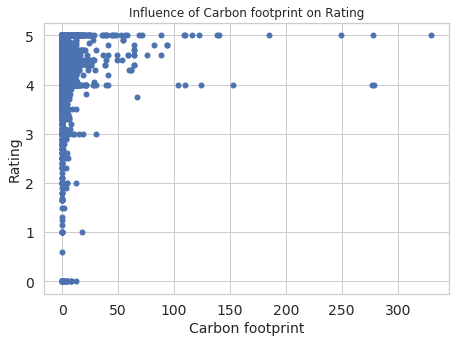

In [9]:
# Scatterplot:
plt.figure(figsize=(16,5))

plt.subplot(121)
plt.scatter(df_clean['Carbon footprint'], df_clean['Rating'], s=25) 
plt.title('Influence of Carbon footprint on Rating')
plt.xlabel('Carbon footprint')
plt.ylabel('Rating')
plt.show()

## Designing a Green Tag for each recipe based on its carbon footprint

Inspired by the tags we find on electronic devices. The recipes without any ingredient figuring in the list of meat types gets tag AA. The rest of the cathegories are established by grouping the recipes into 5 quantiles based on their carbon footprint. With the tag one has access to the information on how bad or how good one is doing compared to the rest of the recipes. We think that this gives a more intuitive estimate for the cook than some number. However, we would like to strike, that between two subsequent labels we observe a difference or around one order of magnitude. This means that for the same carbon footprint of a meal from category E you can cook 100 meals from category C.

In [10]:
# Define colors for each Tag:
color_AA = 'green'
color_A = 'limegreen'
color_B = 'gold'
color_C = 'orange'
color_D = 'red'
color_E = 'darkred'
color_list = [color_AA, color_A, color_B, color_C, color_D, color_E]
tig_list = ['AA', 'A', 'B', 'C', 'D', 'E']

In [11]:
# All Recipes without meat or cheese or eggs receive a rating AA
#df_no_meat['Label']='AA'
A = df_meat['Carbon footprint'].quantile(q=0.2)
B = df_meat['Carbon footprint'].quantile(q=0.4)
C = df_meat['Carbon footprint'].quantile(q=0.6)
D = df_meat['Carbon footprint'].quantile(q=0.8)
E = df_meat['Carbon footprint'].max()

print("The Carbon footprint is labelled as follows:")
print("A = 0 - ",A)
print("B = ", A, " - ",B)
print("C = ", B, " - ",C)
print("D = ", C, " - ",D)
print("E = ", D, " - ",E)

The Carbon footprint is labelled as follows:
A = 0 -  0.0096
B =  0.0096  -  0.0576
C =  0.0576  -  0.5216306628111357
D =  0.5216306628111357  -  2.4007936507936507
E =  2.4007936507936507  -  329.725


In [32]:
df_no_meat = df_no_meat.assign(Label = 'AA')
df_no_meat = df_no_meat.sort_values(by=['Rating'],ascending=False)
df_meat['Label'] = pd.qcut(df_meat['Carbon footprint'], 5, labels=['A','B','C','D','E'],precision=1000)
df_meat = df_meat.sort_values(by=['Label','Rating'],ascending=[True,False])
df_clean = pd.concat([df_no_meat,df_meat])

## Correlations between appreciation and Environmental Impact of a Recipe
As we did not observe a clear correlation the first analysis we explore other means of retrieving information from our dataset.

### Visual Exploration
First we make a hexabin plot for the number of recipes as a function of rating and carbon footprint. We use only recipes with carbon footprint not equal to zero. This gives us the possibility of a log plot, which corresponds also to the logarithmic behaviour of the Green Labels. We observe that there is some pattern in which the recipes are grouped. For our work this plot is very promising, as it shows, that there are many alternative recipes with the same rating or higher for recipes with a high carbon footprint.

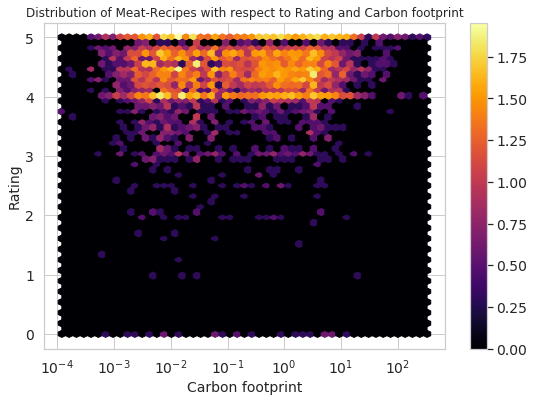

In [13]:
## Hexabinplot of data containing meat, need log plot for x-axis->no zero values
plt.figure(figsize=(9,6))
plt.set_cmap('inferno')
plt.hexbin(df_meat['Carbon footprint'], df_meat['Rating'], gridsize=50, bins='log', xscale='log') 
plt.title('Distribution of Meat-Recipes with respect to Rating and Carbon footprint')
plt.xlabel('Carbon footprint')
plt.ylabel('Rating')
plt.colorbar()
#plt.savefig('hexabin.eps')
plt.show()

Now we look at this histogram of recipes without any ingredient in the high carbon footprint list and the recipes in category A - E. We can see that a higher percentage of recipes with no meat receive an excellent rating. Good News for the planet!!

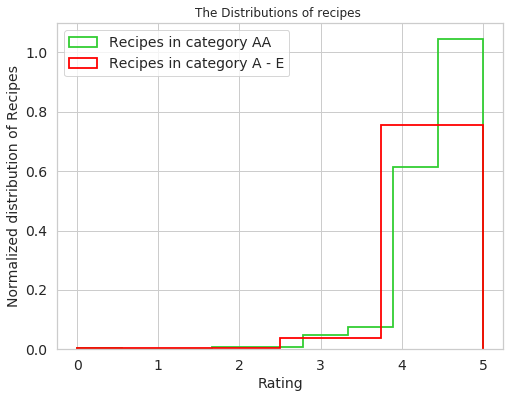

In [29]:
plt.figure(figsize=(8,6))
plt.hist(df_no_meat['Rating'], bins=np.linspace(0,5,10), histtype='step', density=True,\
         color='limegreen', linewidth=1.8, label='Recipes in category AA') 
plt.hist(df_meat['Rating'], bins=np.linspace(0,5,5), histtype='step', density=True, \
         color='red',linewidth=1.8, label='Recipes in category A - E')
plt.xlabel('Rating')
plt.ylabel('Normalized distribution of Recipes')
plt.title('The Distributions of recipes ')
plt.legend(loc=2)
#plt.savefig('DistRec.eps')
plt.show()

### Study of Excellent Recipes

The goal is to cook meals that have only little environmental impact, however the meals should be tasty! This is why we seperately analyse the properties of excellent recipes that we identify with a rating between 4.8 - 5.0. We observe, that both groups AA and E show the highest percentage of excellent recipes.

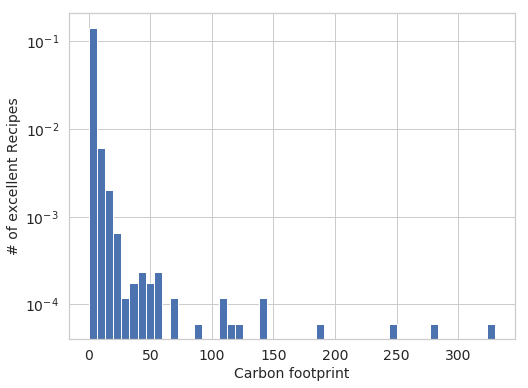

In [15]:
#Show only excellent recipes 4.8-5
df_excellent = df_clean[df_clean['Rating']>4.8]
plt.figure(figsize=(8,6))
plt.hist(df_excellent['Carbon footprint'], bins=50, log=True, density=True)
plt.xlabel('Carbon footprint')
plt.ylabel('# of excellent Recipes')
#plt.title('Distribution of excellent recipes with respect to their Carbon Footprint')
plt.savefig('hist_excellent.eps')
plt.show()

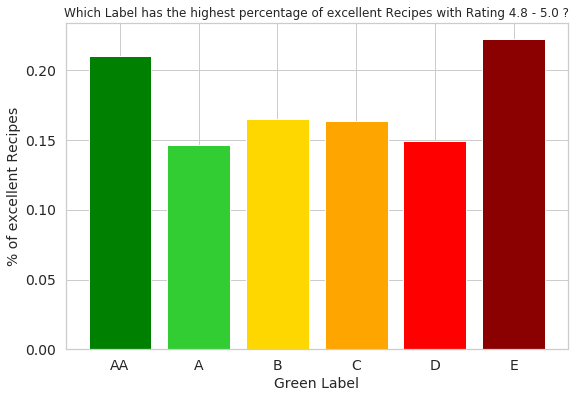

In [33]:
# Group by label and normalize with respect to number of recipes in each group.
h = df_excellent[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='# excellent recipes') \
                         .reindex([1,0,2,3,4,5])
h1 = df_clean[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='#recipes') \
                         .reindex([1,0,2,3,4,5])
df_ex = h.merge(h1)
df_ex['% of excellent recipes'] = df_ex['# excellent recipes']/df_ex['#recipes']

# plot
plt.figure(figsize=(9,6))
plt.bar(df_ex['Label'], df_ex['% of excellent recipes'], \
        color=[color_AA,color_A,color_B,color_C,color_D,color_E], \
        tick_label=tig_list)
plt.xlabel('Green Label')
plt.ylabel('% of excellent Recipes')
plt.title('Which Label has the highest percentage of excellent Recipes with Rating 4.8 - 5.0 ?')
#plt.savefig('excellent.eps')
plt.show()

### Study of Terrible Recipes
For completeness and our curiosity we do the same thing for bad recipes, with rating lower than 2.9. There are some differences between the different categories, but they are too low to be significant.

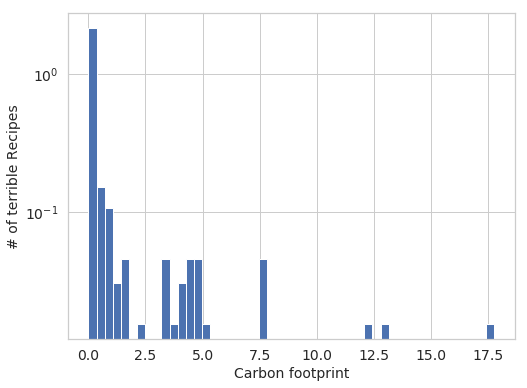

In [26]:
#Show only excellent recipes 4.8-5
df_terrible = df_clean[df_clean['Rating']<3.0]
plt.figure(figsize=(8,6))
plt.hist(df_terrible['Carbon footprint'], bins=50, log=True, density=True)
plt.xlabel('Carbon footprint')
plt.ylabel('# of terrible Recipes')
#plt.title('Distribution of excellent recipes with respect to their Carbon Footprint')
#plt.savefig('hist_excellent.eps')
plt.show()

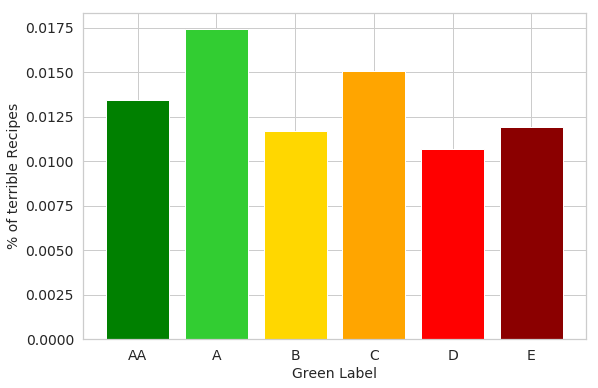

In [30]:
t = df_terrible[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='# excellent recipes') \
                         .reindex([1,0,2,3,4,5])
t1 = df_clean[['Label']].groupby(['Label'])['Label'] \
                         .count() \
                         .reset_index(name='#recipes') \
                         .reindex([1,0,2,3,4,5])
df_ter = t.merge(t1)
df_ter['% of excellent recipes'] = df_ter['# excellent recipes']/df_ter['#recipes']

#plot:

plt.figure(figsize=(9,6))
plt.bar(df_ter['Label'], df_ter['% of excellent recipes'], \
        color=[color_AA,color_A,color_B,color_C,color_D,color_E], \
        tick_label=tig_list)
plt.xlabel('Green Label')
plt.ylabel('% of terrible Recipes')
#plt.title('Which Label has the highest percentage of excellent Recipes with Rating 4.8 - 5.0 ?')
plt.savefig('terrible.eps')
plt.show()

### Brief look on the different recipe pages

We observe, that all of the recipe pages feature a high amount of low carbon footprint recipes, and offer therefore alternatives.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6673f04630>,
      dtype=object)

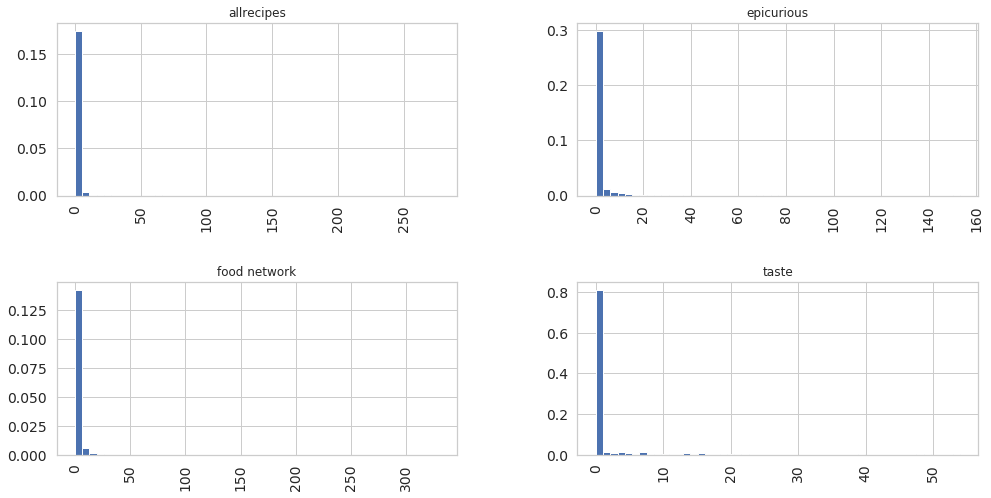

In [22]:
df_clean['Carbon footprint'].hist(by=df_clean['Website'],bins=50,figsize=(16,8),\
                                 xlabelsize=FontSize,ylabelsize=FontSize, density=True)